In [1]:
from time import process_time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rebound
import reboundx
%matplotlib inline

In [2]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11

m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


k1 = 1.0 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1 * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = 1.0 # m_planet/m_Jupiter
m_Planet = k2 * m_J

if k2 <= 0.41:
    R_Planet = R_E * (m_Planet/m_E)**(0.59) # low-mass planet; scale with Earth
else:
    R_Planet = R_J * k2**(-0.04) # massive planet; scale with Jupiter

k_ap = 10
a_Planet = k_ap * R_Sun # or R_Sun

In [3]:
'''
a small planet with Mp = 0.1 MJ and Rp =0.7RJ
a medium-size planet with Mp =MJ and Rp =RJ
a large planet with with Mp =2.0MJ and Rp =2.0RJ
'''

'\na small planet with Mp = 0.1 MJ and Rp =0.7RJ\na medium-size planet with Mp =MJ and Rp =RJ\na large planet with with Mp =2.0MJ and Rp =2.0RJ\n'

In [4]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.G = 6.674e-11 # SI units
sim.dt = 1.e2 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally

sim.add(m = m_Star, r = R_sub, hash = "Star")
sim.add(m = m_Planet, a = a_Planet, e = 0, r = R_Planet, hash = "Planet")
sim.move_to_com()

ps = sim.particles

sim.status()

---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Jun 26 2021 14:35:07
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	100.000000
---------------------------------
<rebound.particle.Particle object at 0x7f8b5260c040, m=1.99e+30 x=-6629047.270492766 y=0.0 z=0.0 vx=0.0 vy=-131.71788839324768 vz=0.0>
<rebound.particle.Particle object at 0x7f8b5260c0c0, m=1.898e+27 x=6950370952.729507 y=0.0 z=0.0 vx=0.0 vy=138102.52787279393 vz=0.0>
---------------------------------


collision function setup
--

In [5]:
hash_Star = str(ps['Star'].hash)
hash_Planet = str(ps['Planet'].hash)

ps_sub = []
ps_pl = []

                  
def collision_function(sim_pointer, collision):
    simcontps = sim_pointer.contents.particles # get simulation object from pointer
    hash_p1 = str(simcontps[collision.p1].hash)
    hash_p2 = str(simcontps[collision.p2].hash)
    
    # p1 not dust              
    if hash_p1 == hash_Star:
        ps_sub.append(hash_p2)
        print ('Sublimation:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                 
    elif hash_p1 == hash_Planet:
        ps_pl.append(hash_p2)
        print ('Hit the Planet:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                  
    # p1 is dust  
    else:
        if hash_p2 == hash_Star:
            ps_sub.append(hash_p1)
            print ('Sublimation:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)
        else:
            ps_pl.append(hash_p1)
            print ('Hit the Planet:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)

    return j                            


sim.collision = "direct"
sim.collision_resolve = collision_function

set up reboundx and radiation force & PR-drag force
--

In [6]:
rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces")
rebx.add_force(rf)
rf.params["c"] = 3.e8


In [7]:
ps["Star"].params["radiation_source"] = 1 # set 'Star' to be the source of radiation

In [8]:
# get beta

if k1 <= 0.43: luminosity = 3.827e+26 * (k1**2.3) # Watts
else: luminosity = 3.827e+26 * (k1**4) # 0.43<k1<2

grain_radius = 3.8 * 1e-6 # grain radius in [m]
density = 1000. # kg/m^3 = 1g/cc
Q_pr = 1.

beta = rebx.rad_calc_beta(sim.G, rf.params["c"], ps[0].m, luminosity, grain_radius, density, Q_pr)

print("beta = {0}".format(beta))

beta = 0.15085709191507718


In [9]:
a = 3*a_Planet
e = 0
inc = 10 # [degree]

Ndust = 1000

import random
seed = 3
random.seed(seed)

for i in range(2, Ndust+2):
#     a = amin + awidth*random.random() # Semimajor axis
    pomega = 2*np.pi*random.random()  # Longitude of pericenter
    f = 2*np.pi*random.random()       # True anomaly
    Omega = 2*np.pi*random.random()   # Longitude of node
#     inc = incmax*random.random()      # Inclination
    sim.add(a=a, e=e, inc=inc*Degree_To_Rad, Omega=Omega, pomega=pomega, f=f, hash=i)
    ps[i].params["beta"] = beta

In [10]:
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

Text(0.5, 1.0, 'Edge-on view')

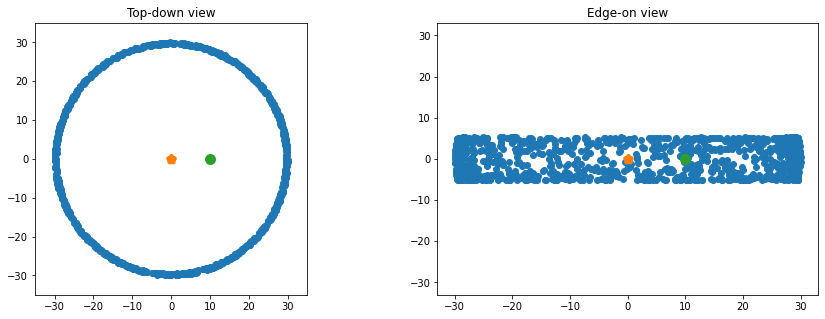

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(np.array(xs)/R_Sun, np.array(ys)/R_Sun)
ax1.scatter(ps[0].x/R_Sun, ps[0].y/R_Sun, marker = '*', linewidth = 5) # Star
ax1.scatter(ps[1].x/R_Sun, ps[1].y/R_Sun, marker = 'o', linewidth = 5) # Planet
ax1.set_xlim([-35, 35])
ax1.set_ylim([-35, 35])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(np.array(xs)/R_Sun, np.array(zs)/R_Sun)
ax2.scatter(ps[0].x/R_Sun, ps[0].z/R_Sun, marker = '*', linewidth = 5) # Star
ax2.scatter(ps[1].x/R_Sun, ps[1].z/R_Sun, marker = 'o', linewidth = 5) # Planet
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

Start Integration
--

In [12]:
# pick out dusts that have been ejected out

# PE + KE wrt Star
def get_E(sim, ps_i):
    rstar = np.array(ps['Star'].xyz)
    r = np.array(ps_i.xyz)
    v = np.array(ps_i.vxyz)
    
    KE = 0.5 * v@v # test particle kinetic energy
    mu = sim.G * ps['Star'].m
    r_ds = r - rstar
    PE = -mu/np.sqrt(r_ds@r_ds) # test particle potential energy
    
    E = KE + PE
    
    return E

In [13]:
start = process_time()

yr = 365*24*3600 # s

Noutput = 1000
times = np.linspace(0, 1e3*yr, Noutput)

N_d = np.zeros(Noutput)

xyzs = []
ps_ej = []

for i, time in enumerate(times):
    sim.integrate(time)
    N_d[i] = sim.N-2
    
    xyzs.append([ps[j].xyz for j in range(sim.N)]) 

    # ejection judgement
    E_ps_array = []
    for j in range(2, sim.N):
        E_ps_array.append(get_E(sim, ps[j]))
    
    index_ej = np.where(np.array(E_ps_array)>0)[0] + 2
    
    l = 0 # count of dusts already removed in this round
    for k in range(len(index_ej)):
        ps_ej.append(str(ps[int(index_ej[k])-l].hash))
        print ('Ejection:', str(ps[int(index_ej[k])-l].hash), 'at %.5f'%(sim.t/yr), '[yr]')
        sim.remove(int(index_ej[k])-l)
        l += 1
            
    if sim.N == 2:
        print ('No dusts left. Finish integration. :)')
        break    


end = process_time()
print("Running time: %s Seconds"%(end-start))  

Hit the Planet: c_uint(943) at 65.16163 [yr]
Hit the Planet: c_uint(678) at 65.67777 [yr]
Hit the Planet: c_uint(37) at 66.20490 [yr]
Hit the Planet: c_uint(168) at 66.39843 [yr]
Sublimation: c_uint(381) at 66.40084 [yr]
Hit the Planet: c_uint(612) at 66.71432 [yr]
Sublimation: c_uint(209) at 66.71551 [yr]
Hit the Planet: c_uint(299) at 66.74145 [yr]
Hit the Planet: c_uint(548) at 66.74675 [yr]
Sublimation: c_uint(769) at 66.75305 [yr]
Hit the Planet: c_uint(977) at 68.28803 [yr]
Hit the Planet: c_uint(422) at 68.77154 [yr]
Hit the Planet: c_uint(675) at 68.79792 [yr]
Sublimation: c_uint(142) at 68.97042 [yr]
Hit the Planet: c_uint(227) at 69.31252 [yr]
Sublimation: c_uint(26) at 69.34639 [yr]
Sublimation: c_uint(554) at 69.52660 [yr]
Sublimation: c_uint(100) at 69.80238 [yr]
Sublimation: c_uint(745) at 70.19393 [yr]
Sublimation: c_uint(891) at 70.50313 [yr]
Sublimation: c_uint(841) at 70.77006 [yr]
Hit the Planet: c_uint(472) at 70.94662 [yr]
Hit the Planet: c_uint(251) at 71.07099 [y

In [14]:
print("Particles in the simulation at t=%5.1f : %d"%(sim.t/yr, sim.N))

Particles in the simulation at t=1000.0 : 10


In [15]:
xs_f = [ps[i].x for i in range(sim.N)]
ys_f = [ps[i].y for i in range(sim.N)]
zs_f = [ps[i].z for i in range(sim.N)]

Text(0.5, 1.0, 'Edge-on view')

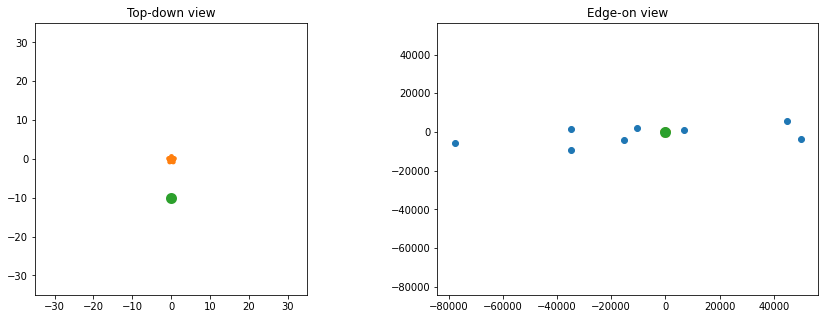

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(np.array(xs_f)/R_Sun, np.array(ys_f)/R_Sun)
ax1.scatter(ps[0].x/R_Sun, ps[0].y/R_Sun, marker = '*', linewidth = 5) # Star
ax1.scatter(ps[1].x/R_Sun, ps[1].y/R_Sun, marker = 'o', linewidth = 5) # Planet
ax1.set_xlim([-35, 35])
ax1.set_ylim([-35, 35])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(np.array(xs_f)/R_Sun, np.array(zs_f)/R_Sun)
ax2.scatter(ps[0].x/R_Sun, ps[0].z/R_Sun, marker = '*', linewidth = 5) # Star
ax2.scatter(ps[1].x/R_Sun, ps[1].z/R_Sun, marker = 'o', linewidth = 5) # Planet
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

movie - inertial frame
--

In [17]:
xs_it = []
ys_it = []
zs_it = []
for i in range(len(xyzs)):
        xs_it.append([j[0] for j in xyzs[i]])
        ys_it.append([j[1] for j in xyzs[i]])
        zs_it.append([j[2] for j in xyzs[i]])
     

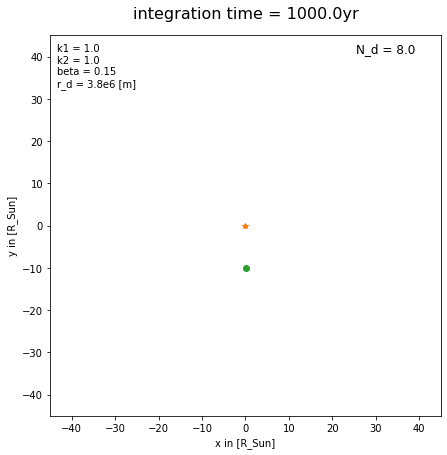

In [25]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)
ax.set_xlabel('x in [R_Sun]')
ax.set_ylabel('y in [R_Sun]')


points, = ax.plot(np.array(xs_it[0])/R_Sun, np.array(ys_it[0])/R_Sun, '.', lw = 5)
points_s, = ax.plot(np.array(xs_it[0][0])/R_Sun, np.array(ys_it[0][0])/R_Sun, '*', lw=8)
points_p, = ax.plot(np.array(xs_it[0][1])/R_Sun, np.array(ys_it[0][1])/R_Sun, 'o', lw=8)

time_template = 'integration time = %.1fyr'
time_text = ax.text(0, 49, '', fontsize=16, ha='center')

para_template = ('N_d = {}')
para_text = ax.text(25.5, 41, '', fontsize=12)

ax.text(-43.5, 30, 'k1 = 1.0\nk2 = 1.0\nbeta = 0.15\nr_d = 3.8e6 [m]\n')


def animate(i):
    points.set_data(np.array(xs_it[i])/R_Sun, np.array(ys_it[i])/R_Sun)
    points_s.set_data(np.array(xs_it[i][0])/R_Sun, np.array(ys_it[i][0])/R_Sun)
    points_p.set_data(np.array(xs_it[i][1])/R_Sun, np.array(ys_it[i][1])/R_Sun)
    time_text.set_text(time_template % (times[i]/yr))
    para_text.set_text(para_template.format(N_d[i]))
    return points, points_s, points_p, time_text, para_text
    
        
ani = animation.FuncAnimation(fig, animate, len(xyzs), interval=150) # len(xyzs)
# ani.save('animation.mp4')
plt.show()


In [19]:
from IPython.display import HTML

HTML(ani.to_html5_video())

movie - rotating frame
--

In [57]:
theta = np.zeros(len(xs_it))
xs_rf = []
ys_rf = []
thetas_rf = []
rs_rf = []
for i in range(len(xs_it)):
    theta[i] = np.arctan2((ys_it[i][1]-ys_it[i][0]), (xs_it[i][1]-xs_it[i][0]))
    xs_rfj, ys_rfj = np.zeros(len(xs_it[i])), np.zeros(len(xs_it[i]))
    thetas_rfj, rs_rfj = np.zeros(len(xs_it[i])), np.zeros(len(xs_it[i]))
    for j in range(len(xs_it[i])):
        xs_rfj[j] = xs_it[i][j] * np.cos(theta[i]) + ys_it[i][j] * np.sin(theta[i])
        ys_rfj[j] = -xs_it[i][j] * np.sin(theta[i]) + ys_it[i][j] * np.cos(theta[i])
        thetas_rfj[j] = np.arctan2(ys_rfj[j], xs_rfj[j])
        rs_rfj[j] = (xs_rfj[j]**2+ys_rfj[j]**2)**0.5
    xs_rf.append(xs_rfj)
    ys_rf.append(ys_rfj)
    thetas_rf.append(thetas_rfj)
    rs_rf.append(rs_rfj)


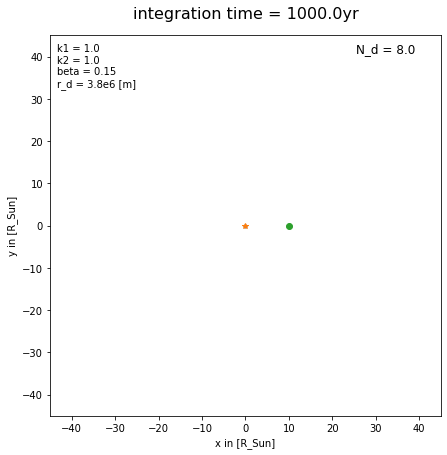

In [56]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)
ax.set_xlabel('x in [R_Sun]')
ax.set_ylabel('y in [R_Sun]')


points, = ax.plot(np.array(xs_rf[0])/R_Sun, np.array(ys_rf[0])/R_Sun, '.', lw = 5)
points_s, = ax.plot(np.array(xs_rf[0][0])/R_Sun, np.array(ys_rf[0][0])/R_Sun, '*', lw=8)
points_p, = ax.plot(np.array(xs_rf[0][1])/R_Sun, np.array(ys_rf[0][1])/R_Sun, 'o', lw=8)

time_template = 'integration time = %.1fyr'
time_text = ax.text(0, 49, '', fontsize=16, ha='center')

para_template = ('N_d = {}')
para_text = ax.text(25.5, 41, '', fontsize=12)

ax.text(-43.5, 30, 'k1 = 1.0\nk2 = 1.0\nbeta = 0.15\nr_d = 3.8e6 [m]\n')


def animate(i):
    points.set_data(np.array(xs_rf[i])/R_Sun, np.array(ys_rf[i])/R_Sun)
    points_s.set_data(np.array(xs_rf[i][0])/R_Sun, np.array(ys_rf[i][0])/R_Sun)
    points_p.set_data(np.array(xs_rf[i][1])/R_Sun, np.array(ys_rf[i][1])/R_Sun)
    time_text.set_text(time_template % (times[i]/yr))
    para_text.set_text(para_template.format(N_d[i]))
    return points, points_s, points_p, time_text, para_text
    
        
ani = animation.FuncAnimation(fig, animate, len(xyzs), interval=150) # len(xyzs)
# ani.save('animation_rf.mp4')
plt.show()



In [55]:
from IPython.display import HTML

HTML(ani.to_html5_video())

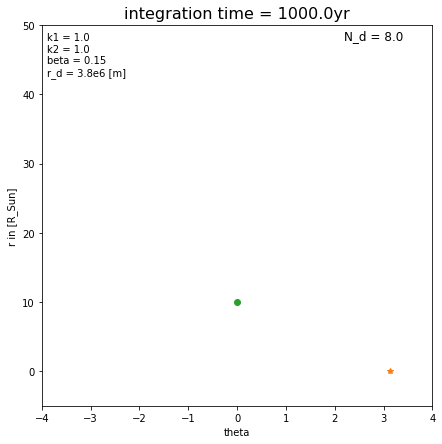

In [73]:
# spherical coordinates

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_xlim(-4, 4)
ax.set_ylim(-5, 50)
ax.set_xlabel('theta')
ax.set_ylabel('r in [R_Sun]')


points, = ax.plot(np.array(thetas_rf[0]), np.array(rs_rf[0])/R_Sun, '.', lw = 5)
points_s, = ax.plot(np.array(thetas_rf[0][0]), np.array(rs_rf[0][0])/R_Sun, '*', lw=8)
points_p, = ax.plot(np.array(thetas_rf[0][1]), np.array(rs_rf[0][1])/R_Sun, 'o', lw=8)

time_template = 'integration time = %.1fyr'
time_text = ax.text(0, 51, '', fontsize=16, ha='center')

para_template = ('N_d = {}')
para_text = ax.text(2.2, 48, '', fontsize=12)

ax.text(-3.9, 41, 'k1 = 1.0\nk2 = 1.0\nbeta = 0.15\nr_d = 3.8e6 [m]\n')


def animate(i):
    points.set_data(np.array(thetas_rf[i]), np.array(rs_rf[i])/R_Sun)
    points_s.set_data(np.array(thetas_rf[i][0]), np.array(rs_rf[i][0])/R_Sun)
    points_p.set_data(np.array(thetas_rf[i][1]), np.array(rs_rf[i][1])/R_Sun)
    time_text.set_text(time_template % (times[i]/yr))
    para_text.set_text(para_template.format(N_d[i]))
    return points, points_s, points_p, time_text, para_text
    
        
ani = animation.FuncAnimation(fig, animate, len(xyzs), interval=150) # len(xyzs)
# ani.save('animation_rf_spherical.mp4')
plt.show()




In [74]:
from IPython.display import HTML

HTML(ani.to_html5_video())